
# 2 and 3 species Competitive Lotka-Volterra

Adapted from the numpyro predator-prey example
http://num.pyro.ai/en/stable/examples/ode.html


In [1]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt

from jax.experimental.ode import odeint
import jax.numpy as jnp
from jax.random import PRNGKey
from jax import nn

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd
import numpy as np

numpyro.set_host_device_count(2)

###   2-species

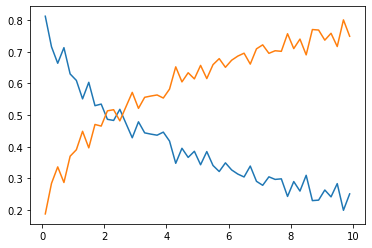

In [2]:
#Recover parameters via inference from data from mathematica simulation for 2 species:
df=pd.read_csv("data/sim.csv", header = None)
week = np.array(df.iloc[:,0])
data = np.array([df.iloc[:,1],df.iloc[:,2]]).T

plt.plot(week, data[:, 0])
plt.plot(week, data[:, 1])
plt.show()

## Fit ODE with Multinomial likeklihood

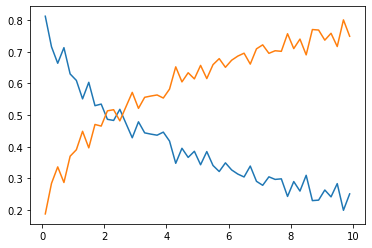

In [3]:
#Recover parameters via inference from data from mathematica simulation for 2 species:
df=pd.read_csv("data/sim.csv", header = None)
week = np.array(df.iloc[:,0])
data = np.array([df.iloc[:,1],df.iloc[:,2]]).T
# data = np.round(100 * np.array([df.iloc[:,1],df.iloc[:,2]]).T)

plt.plot(week, data[:, 0])
plt.plot(week, data[:, 1])
plt.show()

In [88]:
data.sum(1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [4]:
def dz_dt(z, t, theta):

    z1 = z[0]
    z2 = z[1]
    a11, a12, a21, a22 = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
    )
    dz1_dt = z1 * (1 - (a11 * z1 + a12 * z2))
    dz2_dt = z2 * (1 - (a21 * z1 + a22 * z2))
    return jnp.stack([dz1_dt, dz2_dt])


def model(N, y=None):
    """
    :param int N: number of measurement times
    :param numpy.ndarray y: measured populations with shape (N, 2)
    """
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([2]))
    ts = jnp.arange(float(N))
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jnp.array([1.0, 1.0, 1.0, 1.0]),
            scale=jnp.array([0.25, 0.25, 0.25, 0.25]),
        ),
    )
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-6, atol=1e-5, mxstep=1000)
    numpyro.sample("y", dist.Multinomial(logits=z, total_count=100), obs=y)

In [18]:

    
mcmc = MCMC(
    NUTS(model, dense_mass=True),
    num_samples=500,
    num_warmup=500,
    num_chains=1,
#     progress_bar=False,
)
#
# mcmc.print_summary()

In [19]:
 mcmc.run(PRNGKey(1), N = data.shape[0], y = np.round(100 *data))

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.28it/s, 15 steps of size 3.66e-01. acc. prob=0.90]


In [94]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

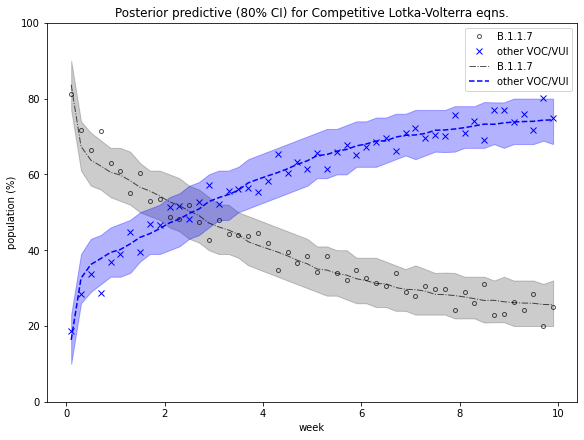

In [97]:
plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, 100 * data[:, 0], "ko", mfc="none", ms=4, label="B.1.1.7", alpha=0.67)
plt.plot(week, 100 * data[:, 1], "bx", label="other VOC/VUI")
plt.plot(week, mu[:, 0], "k-.", label="B.1.1.7", lw=1, alpha=0.67)
plt.plot(week,  mu[:, 1], "b--", label="other VOC/VUI")
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.gca().set(ylim=(0, 100), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Competitive Lotka-Volterra eqns.")
plt.legend()
plt.show()

### 3-species

In [99]:
#Recover parameters via inference from data from mathematica simulation for 3 species:
df=pd.read_csv("data/sim3.csv", header = None)
week = np.array(df.iloc[:,0])
data = np.array([df.iloc[:,1],df.iloc[:,2],df.iloc[:,3]]).T

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [100]:
# rounding fails if you have three so just need to do some sort of data massaging
print(np.round(100 *data))
trans_data =  np.round(100 *data)
trans_data[:,2] = 100 - (trans_data[:,0] + trans_data[:,1])
print(trans_data)

[[75.  7. 19.]
 [67. 13. 20.]
 [59.  8. 33.]
 [50. 12. 38.]
 [44. 12. 44.]
 [42. 13. 45.]
 [37. 12. 51.]
 [30. 14. 56.]
 [25. 17. 58.]
 [23. 19. 58.]
 [23. 14. 63.]
 [20. 15. 65.]
 [16. 20. 65.]
 [13. 18. 69.]
 [13. 18. 69.]
 [10. 27. 63.]
 [ 9. 23. 69.]
 [ 6. 30. 64.]
 [ 8. 35. 57.]
 [ 4. 36. 60.]
 [ 2. 35. 62.]
 [ 6. 35. 59.]
 [ 2. 40. 59.]
 [ 2. 42. 55.]
 [ 4. 44. 51.]
 [ 4. 53. 43.]
 [ 3. 50. 47.]
 [ 1. 53. 46.]
 [ 1. 59. 40.]
 [ 2. 61. 37.]
 [ 0. 65. 34.]
 [ 0. 64. 36.]
 [ 1. 69. 29.]
 [ 3. 68. 29.]
 [ 0. 70. 30.]
 [ 0. 78. 22.]
 [ 0. 80. 20.]
 [ 0. 79. 21.]
 [ 2. 83. 16.]
 [ 0. 86. 14.]
 [ 0. 89. 10.]
 [ 2. 92.  6.]
 [ 0. 93.  7.]
 [ 1. 86. 13.]
 [ 0. 88. 12.]
 [ 1. 90.  8.]
 [ 2. 92.  6.]
 [ 0. 89. 11.]
 [ 0. 94.  6.]
 [ 0. 96.  4.]]
[[75.  7. 18.]
 [67. 13. 20.]
 [59.  8. 33.]
 [50. 12. 38.]
 [44. 12. 44.]
 [42. 13. 45.]
 [37. 12. 51.]
 [30. 14. 56.]
 [25. 17. 58.]
 [23. 19. 58.]
 [23. 14. 63.]
 [20. 15. 65.]
 [16. 20. 64.]
 [13. 18. 69.]
 [13. 18. 69.]
 [10. 27. 63.]
 [ 9. 23.

In [102]:
trans_data.sum(1)

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100.])

In [103]:
def dz_dt(z, t, theta):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    a1, a11, a12, a13, a21, a2, a22, a23, a3, a31, a32, a33 = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
        theta[..., 4],
        theta[..., 5],
        theta[..., 6],
        theta[..., 7],
        theta[..., 8],
        theta[..., 9],
        theta[..., 10],
        theta[..., 11]
    )
    dz1_dt = a1 * z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3))
    dz2_dt = a2 * z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3))
    dz3_dt = a3 * z3 * (1 - (a31 * z1 + a32 * z2 + a33 * z3))
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt])


def model(N, y=None):
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([3]))
    # measurement times
    ts = jnp.arange(float(N))
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jnp.array([1.0, 1.0, 1.0, 1.0,1.0,1.0, 1.0,1.0,1.0, 1.0,1.0,1.0]),
            scale=jnp.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
        ),
    )
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-7, atol=1e-6, mxstep=1000)
    numpyro.sample("y", dist.Multinomial(logits=z, total_count=100), obs=y)
    
mcmc = MCMC(
    NUTS(model, dense_mass=True),
    num_samples=500,
    num_warmup=500,
    num_chains=2,
    progress_bar=False,
)

mcmc.run(PRNGKey(1), N=trans_data.shape[0], y=trans_data)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.15      0.14      0.17      0.00      0.29      1.00     47.84
  theta[1]      2.61      1.90      3.34      0.32      4.50      1.02      7.21
  theta[2]      0.62      0.55      0.21      0.20      1.63      1.46      1.71
  theta[3]      0.70      0.47      0.34      0.34      1.47      1.45      1.66
  theta[4]      0.48      0.35      0.56      0.10      0.84      1.00     14.59
  theta[5]      1.68      1.51      1.74      0.13      3.19      1.00     54.40
  theta[6]      0.41      0.31      0.44      0.08      0.73      1.00     26.06
  theta[7]      0.34      0.28      0.40      0.03      0.62      1.01     12.35
  theta[8]      1.16      1.16      1.15      0.00      2.33      1.00    349.69
  theta[9]      0.79      0.37      0.64      0.13      1.35      8.45      1.13
 theta[10]      0.96      0.32      0.93      0.29      1.51    331.62      1.01
 theta[11]      0.59      0

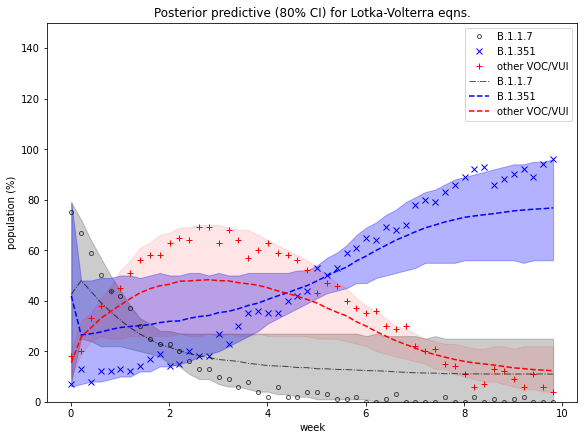

In [105]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), trans_data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, trans_data[:, 0], "ko", mfc="none", ms=4, label="B.1.1.7", alpha=0.67)
plt.plot(week, trans_data[:, 1], "bx", label="B.1.351")
plt.plot(week, trans_data[:, 2], "r+", label="other VOC/VUI")
plt.plot(week, mu[:, 0], "k-.", label="B.1.1.7", lw=1, alpha=0.67)
plt.plot(week, mu[:, 1], "b--", label="B.1.351")
plt.plot(week, mu[:, 2], "r--", label="other VOC/VUI")
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
plt.gca().set(ylim=(0, 150), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Lotka-Volterra eqns.")
plt.legend()
plt.show()

In [124]:
Scomp = 0.01 # downscale the competitive interaction
Svar = 0.1 # downscale the variance
def dz_dt(z, t, theta):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    a1, a11, a12, a13, a21, a2, a22, a23, a3, a31, a32, a33 = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
        theta[..., 4],
        theta[..., 5],
        theta[..., 6],
        theta[..., 7],
        theta[..., 8],
        theta[..., 9],
        theta[..., 10],
        theta[..., 11]
    )
    dz1_dt = a1 * z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3))
    dz2_dt = a2 * z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3))
    dz3_dt = a3 * z3 * (1 - (a31 * z1 + a32 * z2 + a33 * z3))
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt])


def model(N, y=None):
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([3]))
    # measurement times
    ts = jnp.arange(float(N))
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jnp.array([1.0, 1.0, 1.0 * Scomp, 1.0 * Scomp, 
                           1.0 * Scomp, 1.0, 1.0, 1.0 * Scomp, 
                           1.0, 1.0 * Scomp, 1.0 * Scomp, 1.0]),
            scale= S1 * jnp.repeat(0.5, 12),
        ),
    )
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-7, atol=1e-6, mxstep=1000)
    numpyro.sample("y", dist.Multinomial(logits=z, total_count=100), obs=y)
    
mcmc = MCMC(
    NUTS(model, dense_mass=True),
    num_samples=500,
    num_warmup=500,
    num_chains=2,
    progress_bar=False,
)

mcmc.run(PRNGKey(1), N=trans_data.shape[0], y=trans_data)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.99      0.05      0.99      0.91      1.07    729.29      1.00
  theta[1]      0.78      0.06      0.78      0.69      0.88    108.38      1.02
  theta[2]      0.30      0.05      0.30      0.21      0.37     49.13      1.07
  theta[3]      0.14      0.04      0.14      0.07      0.21    102.83      1.03
  theta[4]      0.24      0.04      0.24      0.18      0.31     66.44      1.05
  theta[5]      0.95      0.05      0.95      0.87      1.03    501.61      1.00
  theta[6]      0.07      0.02      0.07      0.04      0.10    230.02      1.01
  theta[7]      0.31      0.02      0.31      0.27      0.34    125.03      1.04
  theta[8]      0.93      0.05      0.93      0.84      1.02    237.35      1.02
  theta[9]      0.28      0.06      0.29      0.15      0.37     22.49      1.15
 theta[10]      0.05      0.02      0.05      0.01      0.09     42.04      1.07
 theta[11]      0.35      0

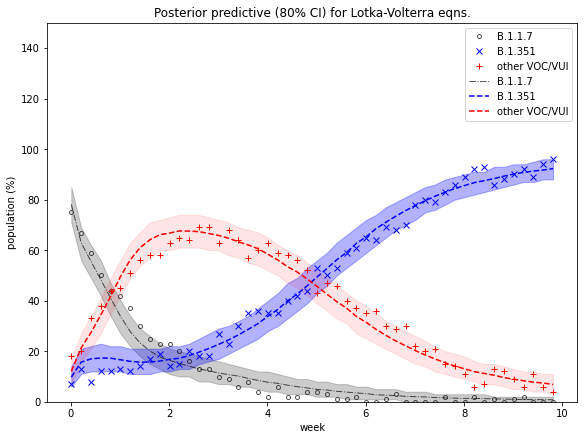

In [125]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), trans_data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, trans_data[:, 0], "ko", mfc="none", ms=4, label="B.1.1.7", alpha=0.67)
plt.plot(week, trans_data[:, 1], "bx", label="B.1.351")
plt.plot(week, trans_data[:, 2], "r+", label="other VOC/VUI")
plt.plot(week, mu[:, 0], "k-.", label="B.1.1.7", lw=1, alpha=0.67)
plt.plot(week, mu[:, 1], "b--", label="B.1.351")
plt.plot(week, mu[:, 2], "r--", label="other VOC/VUI")
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
plt.gca().set(ylim=(0, 150), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Lotka-Volterra eqns.")
plt.legend()
plt.show()

## Four species

In [126]:
#Recover parameters via inference from data from mathematica simulation for 3 species:
df=pd.read_csv("data/sim3.csv", header = None)
week = np.array(df.iloc[:,0])
data = np.array([df.iloc[:,1],df.iloc[:,2],df.iloc[:,3]]).T




In [225]:
# rounding fails if you have three so just need to do some sort of data massaging
trans_data2 =  np.round(100 * data)
trans_data[:,2] = 100 - (trans_data[:,0] + trans_data[:,1])
col12 = trans_data[...,0:2]
col4 = np.random.randint(0, 4, trans_data.shape[0])
col3 = trans_data[...,2] - col4
trans_data = np.append(col12, np.append([col3], [col4],0).T, 1)

In [226]:
trans_data

array([[75.,  7., 17.,  1.],
       [67., 13., 18.,  2.],
       [59.,  8., 31.,  2.],
       [50., 12., 35.,  3.],
       [44., 12., 41.,  3.],
       [42., 13., 45.,  0.],
       [37., 12., 48.,  3.],
       [30., 14., 53.,  3.],
       [25., 17., 56.,  2.],
       [23., 19., 57.,  1.],
       [23., 14., 63.,  0.],
       [20., 15., 64.,  1.],
       [16., 20., 61.,  3.],
       [13., 18., 67.,  2.],
       [13., 18., 66.,  3.],
       [10., 27., 61.,  2.],
       [ 9., 23., 65.,  3.],
       [ 6., 30., 63.,  1.],
       [ 8., 35., 54.,  3.],
       [ 4., 36., 57.,  3.],
       [ 2., 35., 62.,  1.],
       [ 6., 35., 56.,  3.],
       [ 2., 40., 56.,  2.],
       [ 2., 42., 53.,  3.],
       [ 4., 44., 49.,  3.],
       [ 4., 53., 42.,  1.],
       [ 3., 50., 45.,  2.],
       [ 1., 53., 46.,  0.],
       [ 1., 59., 40.,  0.],
       [ 2., 61., 37.,  0.],
       [ 0., 65., 32.,  3.],
       [ 0., 64., 35.,  1.],
       [ 1., 69., 27.,  3.],
       [ 3., 68., 28.,  1.],
       [ 0., 7

In [234]:
Scomp = 0.01 # downscale the competitive interaction
Svar = 0.1 # downscale the variance
def dz_dt(z, t, theta):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    z4 = z[3]
    a1, a11, a12, a13, a14, a21, a2, a22, a23, a24, a3, a31, a32, a33, a34, a4, a41, a42, a43, a44,  = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
        theta[..., 4],
        theta[..., 5],
        theta[..., 6],
        theta[..., 7],
        theta[..., 8],
        theta[..., 9],
        theta[..., 10],
        theta[..., 11],
        theta[..., 12],
        theta[..., 13],
        theta[..., 14],
        theta[..., 15],
        theta[..., 16],
        theta[..., 17],
        theta[..., 18],
        theta[..., 19],
    )
    dz1_dt = a1 * z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3 + a14 * z4))
    dz2_dt = a2 * z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3 + a24 * z4))
    dz3_dt = a3 * z3 * (1 - (a31 * z1 + a32 * z2 + a33 * z3 + a34 * z4))
    dz4_dt = a4 * z4 * (1 - (a41 * z1 + a42 * z2 + a43 * z3 + a44 * z4))
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt, dz4_dt])


def model(N, y=None):
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([4]))
    # measurement times
    ts = jnp.arange(float(N))
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc=jnp.array([1.0, 1.0,         1.0 * Scomp, 1.0 * Scomp, 1.0 * Scomp, 
                           1.0, 1.0 * Scomp, 1.0,         1.0 * Scomp, 1.0 * Scomp, 
                           1.0, 1.0 * Scomp, 1.0 * Scomp, 1.0,         1.0 * Scomp,
                           1.0, 1.0 * Scomp, 1.0 * Scomp, 1.0 * Scomp, 1.0,
                          ]),
            scale= S1 * jnp.repeat(0.5, 20),
        ),
    )
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-7, atol=1e-6, mxstep=1000)
    numpyro.sample("y", dist.Multinomial(logits=z, total_count=100), obs=y)
    
mcmc = MCMC(
    NUTS(model, dense_mass=True),
    num_samples=500,
    num_warmup=500,
    num_chains=2,
    progress_bar=False,
)

mcmc.run(PRNGKey(1), N=trans_data.shape[0], y=trans_data)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.82      0.14      0.75      0.69      1.00      1.04      4.39
  theta[1]      1.67      0.91      1.75      0.72      2.58       nan     27.24
  theta[2]      1.87      1.69      1.91      0.16      3.55      1.00    115.42
  theta[3]      3.21      3.05      3.26      0.13      6.26      1.00    147.15
  theta[4]      0.12      0.08      0.18      0.02      0.20      1.04      4.51
  theta[5]      1.24      0.46      1.32      0.74      1.70      1.01     13.24
  theta[6]      0.34      0.09      0.39      0.23      0.43      1.03      5.40
  theta[7]      0.91      0.71      0.92      0.20      1.62      1.00    139.45
  theta[8]      0.11      0.10      0.11      0.00      0.21      1.00     55.54
  theta[9]      2.35      2.32      2.40      0.01      4.66      1.00    152.72
 theta[10]      1.42      0.51      1.51      0.87      1.93      1.00     16.04
 theta[11]      0.31      0

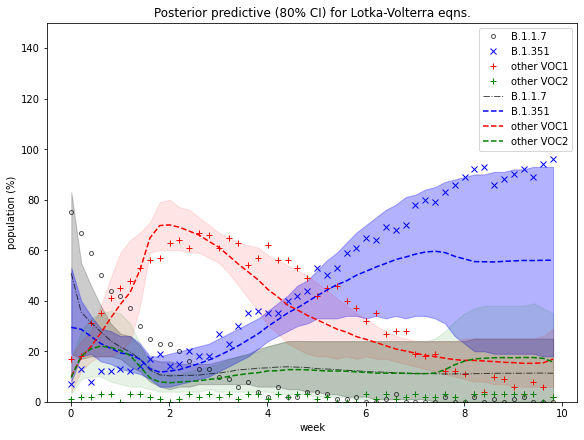

In [235]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), trans_data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, trans_data[:, 0], "ko", mfc="none", ms=4, label="B.1.1.7", alpha=0.67)
plt.plot(week, trans_data[:, 1], "bx", label="B.1.351")
plt.plot(week, trans_data[:, 2], "r+", label="other VOC1")
plt.plot(week, trans_data[:, 3], "g+", label="other VOC2")
plt.plot(week, mu[:, 0], "k-.", label="B.1.1.7", lw=1, alpha=0.67)
plt.plot(week, mu[:, 1], "b--", label="B.1.351")
plt.plot(week, mu[:, 2], "r--", label="other VOC1")
plt.plot(week, mu[:, 3], "g--", label="other VOC2")
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
plt.fill_between(week, pi[0, :, 3], pi[1, :, 3], color="g", alpha=0.1)
plt.gca().set(ylim=(0, 150), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Lotka-Volterra eqns.")
plt.legend()
plt.show()

In [236]:
Scomp = 0.01 # downscale the competitive interaction
Svar = 0.01 # downscale the variance
def dz_dt(z, t, theta):

    z1 = z[0]
    z2 = z[1]
    z3 = z[2]
    z4 = z[3]
    a1, a11, a12, a13, a14, a21, a2, a22, a23, a24, a3, a31, a32, a33, a34, a4, a41, a42, a43, a44,  = (
        theta[..., 0],
        theta[..., 1],
        theta[..., 2],
        theta[..., 3],
        theta[..., 4],
        theta[..., 5],
        theta[..., 6],
        theta[..., 7],
        theta[..., 8],
        theta[..., 9],
        theta[..., 10],
        theta[..., 11],
        theta[..., 12],
        theta[..., 13],
        theta[..., 14],
        theta[..., 15],
        theta[..., 16],
        theta[..., 17],
        theta[..., 18],
        theta[..., 19],
    )
    dz1_dt = a1 * z1 * (1 - (a11 * z1 + a12 * z2 + a13 * z3 + a14 * z4))
    dz2_dt = a2 * z2 * (1 - (a21 * z1 + a22 * z2 + a23 * z3 + a24 * z4))
    dz3_dt = a3 * z3 * (1 - (a31 * z1 + a32 * z2 + a33 * z3 + a34 * z4))
    dz4_dt = a4 * z4 * (1 - (a41 * z1 + a42 * z2 + a43 * z3 + a44 * z4))
    return jnp.stack([dz1_dt, dz2_dt, dz3_dt, dz4_dt])


def model(N, y=None):
    # initial population
    z_init = numpyro.sample("z_init", dist.LogNormal(jnp.log(10), 1).expand([4]))
    # measurement times
    ts = jnp.arange(float(N))
    theta = numpyro.sample(
        "theta",
        dist.TruncatedNormal(
            low=0.0,
            loc= Scomp * jnp.repeat(1, 20),
            scale= Svar * jnp.repeat(1, 20),
        ),
    )
    z = odeint(dz_dt, z_init, ts, theta, rtol=1e-7, atol=1e-6, mxstep=1000)
    numpyro.sample("y", dist.Multinomial(logits=z, total_count=100), obs=y)
    
mcmc = MCMC(
    NUTS(model, dense_mass=True),
    num_samples=500,
    num_warmup=500,
    num_chains=2,
    progress_bar=False,
)

mcmc.run(PRNGKey(1), N=trans_data.shape[0], y=trans_data)
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.00      0.00      0.00      0.00      0.01    366.81      1.01
  theta[1]      0.01      0.01      0.01      0.00      0.03    459.95      1.00
  theta[2]      0.01      0.01      0.01      0.00      0.02    542.78      1.00
  theta[3]      0.01      0.01      0.01      0.00      0.02    435.34      1.00
  theta[4]      0.01      0.01      0.01      0.00      0.02    657.54      1.00
  theta[5]      0.01      0.00      0.00      0.00      0.01    745.27      1.00
  theta[6]      0.03      0.01      0.04      0.03      0.04    407.65      1.00
  theta[7]      0.01      0.01      0.01      0.00      0.02    455.61      1.00
  theta[8]      0.01      0.00      0.01      0.00      0.01    572.64      1.00
  theta[9]      0.01      0.01      0.01      0.00      0.02    362.11      1.00
 theta[10]      0.05      0.01      0.05      0.04      0.05    658.21      1.00
 theta[11]      0.00      0

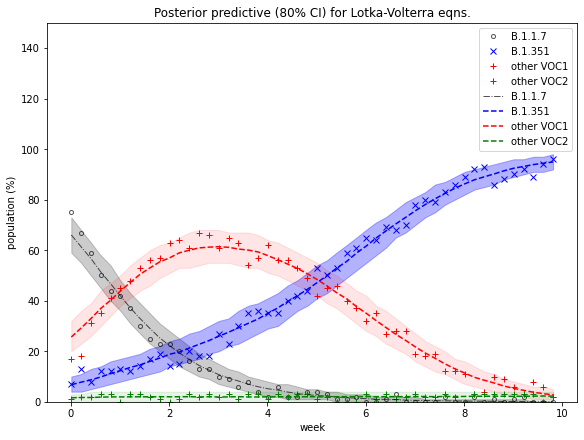

In [237]:
pop_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), trans_data.shape[0])["y"]
mu, pi = jnp.mean(pop_pred, 0), np.percentile(pop_pred, (10, 90), 0)

plt.figure(figsize=(8, 6), constrained_layout=True)
plt.plot(week, trans_data[:, 0], "ko", mfc="none", ms=4, label="B.1.1.7", alpha=0.67)
plt.plot(week, trans_data[:, 1], "bx", label="B.1.351")
plt.plot(week, trans_data[:, 2], "r+", label="other VOC1")
plt.plot(week, trans_data[:, 3], "g+", label="other VOC2")
plt.plot(week, mu[:, 0], "k-.", label="B.1.1.7", lw=1, alpha=0.67)
plt.plot(week, mu[:, 1], "b--", label="B.1.351")
plt.plot(week, mu[:, 2], "r--", label="other VOC1")
plt.plot(week, mu[:, 3], "g--", label="other VOC2")
plt.fill_between(week, pi[0, :, 0], pi[1, :, 0], color="k", alpha=0.2)
plt.fill_between(week, pi[0, :, 1], pi[1, :, 1], color="b", alpha=0.3)
plt.fill_between(week, pi[0, :, 2], pi[1, :, 2], color="r", alpha=0.1)
plt.fill_between(week, pi[0, :, 3], pi[1, :, 3], color="g", alpha=0.1)
plt.gca().set(ylim=(0, 150), xlabel="week", ylabel="population (%)")
plt.title("Posterior predictive (80% CI) for Lotka-Volterra eqns.")
plt.legend()
plt.show()